# 사기탐지 신용카드 데이터분석

- 신원 도용, 계정 인수, 거래 사기를 포함하되 이에 국한되지 않는 다양한 유형의 사기에 대한 데이터를 수집하는 것이 포함됨

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# 밑에 실행하면서 뜨는 빨간 경고 팝업 뜨지 않게 하기 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib   # 한국어 출력되게 
import os
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
import plotly.graph_objs as go
import pmdarima as pm
from pmdarima.arima import ndiffs

### 칼럼 설명

- trans_date_trans_time (object): 거래가 발생한 날짜 및 시간
- cc_num (int64): 사용된 신용카드 번호를 나타내는 숫자
- merchant (object): 상점명 또는 거래가 발생한 가맹점의 이름
- category (object): 거래가 발생한 상품 또는 서비스의 범주
- amt (float64): 해당 거래의 거래 금액
- first (object): 카드 소유자의 이름
- last (object): 카드 소유자의 성
- gender (object): 카드 소유자의 성별
- street (object): 카드 소유자의 거주지 주소의 거리
- city (object): 카드 소유자의 거주지 도시
- state (object): 카드 소유자의 거주지 주(State)
- zip (int64): 카드 소유자의 거주지 우편번호
- lat (float64): 카드 소유자의 거주지 위도(latitude)
- long (float64): 카드 소유자의 거주지 경도(longitude)
- city_pop (int64): 카드 소유자가 거주하는 도시의 인구 수
- job (object): 카드 소유자의 직업
- dob (object): 카드 소유자의 출생일(Date of Birth)
- trans_num (object): 각 거래에 할당된 고유 거래 번호
- unix_time (int64): 거래가 발생한 시간을 유닉스 타임스탬프 형식으로 나타낸 값
- merch_lat (float64): 가맹점의 위도(latitude) 거래가 발생한 상점의 위치 정보
- merch_long (float64): 가맹점의 경도(longitude)
- is_fraud (int64): 거래가 사기(fraud)여부를 나타내는 열입니다. 1은 사기, 0은 정상 거래


In [3]:
data = pd.read_csv("./data/creaditcard_fraud_data.csv")
data

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,...,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,...,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,...,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,...,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


1. 데이터 전처리(결측값, 이상값)
2. EDA
3. Feature Engineering
4. Feature Selection
5. 데이터 분할
6. k-fold 교차검증, gridsearch, randomsearch, 데이터 증폭 pipeline 이용해서 모델 3가지로 비교 분석


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int

In [5]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1852394 non-null  object 
 1   cc_num                 1852394 non-null  int64  
 2   merchant               1852394 non-null  object 
 3   category               1852394 non-null  object 
 4   amt                    1852394 non-null  float64
 5   first                  1852394 non-null  object 
 6   last                   1852394 non-null  object 
 7   gender                 1852394 non-null  object 
 8   street                 1852394 non-null  object 
 9   city                   1852394 non-null  object 
 10  state                  1852394 non-null  object 
 11  zip                    1852394 non-null  int64  
 12  lat                    1852394 non-null  float64
 13  long                   1852394 non-null  float64
 14  city_pop          

In [6]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [7]:
# float 형식의 숫자를 소수점 아래 6자리까지 출력

pd.options.display.float_format = '{:.6f}'.format

In [8]:
data.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000
mean,417386038393710400.000000,70.063567,48813.258191,38.539311,-90.227832,88643.674509,1358674218.834364,38.538976,-90.227940,0.005210
std,1309115265318734848.000000,159.253975,26881.845966,5.071470,13.747895,301487.618344,18195081.387560,5.105604,13.759692,0.071992
min,60416207185.000000,1.000000,1257.000000,20.027100,-165.672300,23.000000,1325376018.000000,19.027422,-166.671575,0.000000
25%,180042946491150.000000,9.640000,26237.000000,34.668900,-96.798000,741.000000,1343016823.750000,34.740122,-96.899440,0.000000
50%,3521417320836166.000000,47.450000,48174.000000,39.354300,-87.476900,2443.000000,1357089331.000000,39.368900,-87.440694,0.000000
75%,4642255475285942.000000,83.100000,72042.000000,41.940400,-80.158000,20328.000000,1374581485.250000,41.956263,-80.245108,0.000000
max,4992346398065154048.000000,28948.900000,99921.000000,66.693300,-67.950300,2906700.000000,1388534374.000000,67.510267,-66.950902,1.000000


### 데이터가 많기 때문에 train 과 test 미리 쪼개기

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train, test = train_test_split(data, stratify=data['is_fraud'], test_size=0.4, random_state=10)

In [11]:
train['is_fraud'].value_counts()

is_fraud
0    1105645
1       5791
Name: count, dtype: int64

In [12]:
test['is_fraud'].value_counts()

is_fraud
0    737098
1      3860
Name: count, dtype: int64

In [13]:
train

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1349054,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,Kimberly,Myers,F,6881 King Isle Suite 228,Higganum,...,41.468200,-72.575100,5438,"Librarian, academic",1964-11-17,a8387a0ac06859a5f59c4402373349bf,1373352780,41.809910,-73.494581,0
508153,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,Jacqueline,Curry,F,3047 Jeff Place,Marathon,...,30.188600,-103.221400,498,Lexicographer,1990-11-23,fc1c7c5e5636de2b112502d4190af08a,1344450052,30.858585,-102.458928,0
912706,2019-12-29 14:00:23,349612764943496,fraud_Windler LLC,kids_pets,42.420000,Xavier,Beltran,M,61107 Edwards Dam Apt. 463,Big Creek,...,37.104600,-83.570600,467,"Psychologist, forensic",1984-06-04,ed691345ae57dfdd2b4d954c12c1a258,1356789623,36.405837,-84.030634,0
530344,2019-08-16 18:02:28,4874017206859125,"fraud_Prosacco, Kreiger and Kovacek",home,77.050000,Lauren,Williams,F,065 Jones Stravenue,Lake Oswego,...,45.409300,-122.684700,42817,Planning and development surveyor,1982-05-28,a0cff5117b395e72c671f25775441b41,1345140148,46.111612,-121.729974,0
1126761,2020-04-14 00:21:46,5501083170975659,fraud_Jast Ltd,shopping_net,1.950000,Wayne,Payne,M,587 Bradley Inlet Suite 281,Cuyahoga Falls,...,41.146400,-81.510700,47772,Equities trader,1966-01-04,5c9502a41a88ac02f815cd475d67e770,1365898906,40.945120,-82.361809,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365820,2020-07-14 19:29:36,676369110710,fraud_Nienow PLC,entertainment,11.330000,David,Wolfe,M,81261 Garcia Underpass Suite 741,Southfield,...,42.496900,-83.291100,75830,"Engineer, automotive",1974-12-28,8974c45a49a27af12e7c7865b7d5b473,1373830176,41.566847,-84.015768,0
105708,2019-03-02 15:25:33,30238755902988,fraud_Macejkovic-Lesch,shopping_pos,4.870000,Danielle,Yu,F,5395 Colon Burgs Suite 037,Thrall,...,30.592000,-97.289300,1766,Press sub,1976-01-02,7d447874731680f0034ef6b77156d0b0,1330701933,30.892429,-97.713717,0
602068,2019-09-13 03:44:55,4099707841315751,fraud_Hackett-Lueilwitz,grocery_pos,70.320000,James,Stephens,M,1166 Castillo Mountains,Ruckersville,...,38.258600,-78.407400,9815,"Designer, ceramics/pottery",1975-07-07,754ac0c8aa484227b6654995fedf7726,1347507895,38.195483,-78.668541,0
1780135,2020-12-15 16:09:57,345933964507467,"fraud_Wuckert, Wintheiser and Friesen",home,121.300000,Carol,Dillon,F,27479 Reeves Dale,Whaleyville,...,38.412100,-75.281100,718,Regulatory affairs officer,1985-03-19,3c690a91a177f380e09770b7a2fbef3b,1387123797,38.001255,-76.190657,0


In [14]:
train['cc_num'].nunique()



999

In [15]:
train['name'] = train['first'] + " " + train['last']
train['name'].nunique()
# 중복되는 값 빼고 이름 총 개수

989

In [16]:
train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,name
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.178100,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,Jennifer Banks
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.210500,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,Stephanie Gill
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.262000,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,Edward Sanchez
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.113800,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,Jeremy White
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.462900,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,Tyler Garcia


In [17]:
train = train.drop(['first', 'last', 'street','city','zip','trans_num','unix_time', 'name'],axis=1)
train.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,state,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,F,NC,36.078800,-81.178100,3495,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,F,WA,48.887800,-118.210500,149,Special educational needs teacher,1978-06-21,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,M,ID,42.180800,-112.262000,4154,Nature conservation officer,1962-01-19,43.150704,-112.154481,0


### 카드 번호에 따른 평균 지출액, 표준편차 구하기 

In [18]:
train.groupby('cc_num')['amt'].agg(['mean', 'std']).reset_index()

,cc_num,mean,std
0,60416207185,61.313763,161.657736
1,60422928733,65.278174,90.900398
2,60423098130,116.621949,1248.438561
3,60427851591,104.790490,119.746806
4,60487002085,70.822757,182.542688
...,...,...,...
994,4958589671582726883,68.121702,156.519908
995,4973530368125489546,69.837241,136.312982
996,4980323467523543940,71.559318,126.591056
997,4989847570577635369,93.801177,136.023783


In [19]:
amt_by_cc_num = train.groupby('cc_num')['amt'].agg(['mean', 'std']).reset_index()
amt_by_cc_num 

,cc_num,mean,std
0,60416207185,61.313763,161.657736
1,60422928733,65.278174,90.900398
2,60423098130,116.621949,1248.438561
3,60427851591,104.790490,119.746806
4,60487002085,70.822757,182.542688
...,...,...,...
994,4958589671582726883,68.121702,156.519908
995,4973530368125489546,69.837241,136.312982
996,4980323467523543940,71.559318,126.591056
997,4989847570577635369,93.801177,136.023783


In [20]:
train = pd.merge(train, amt_by_cc_num, how='left', on='cc_num')
train.head()

# 맨 뒤에 mean, std 칼럼 합쳐짐

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,mean,std
0,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,Kimberly,Myers,F,6881 King Isle Suite 228,Higganum,...,5438,"Librarian, academic",1964-11-17,a8387a0ac06859a5f59c4402373349bf,1373352780,41.809910,-73.494581,0,73.414795,131.574335
1,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,Jacqueline,Curry,F,3047 Jeff Place,Marathon,...,498,Lexicographer,1990-11-23,fc1c7c5e5636de2b112502d4190af08a,1344450052,30.858585,-102.458928,0,59.766495,147.773396
2,2019-12-29 14:00:23,349612764943496,fraud_Windler LLC,kids_pets,42.420000,Xavier,Beltran,M,61107 Edwards Dam Apt. 463,Big Creek,...,467,"Psychologist, forensic",1984-06-04,ed691345ae57dfdd2b4d954c12c1a258,1356789623,36.405837,-84.030634,0,97.885517,103.125597
3,2019-08-16 18:02:28,4874017206859125,"fraud_Prosacco, Kreiger and Kovacek",home,77.050000,Lauren,Williams,F,065 Jones Stravenue,Lake Oswego,...,42817,Planning and development surveyor,1982-05-28,a0cff5117b395e72c671f25775441b41,1345140148,46.111612,-121.729974,0,89.205841,127.017879
4,2020-04-14 00:21:46,5501083170975659,fraud_Jast Ltd,shopping_net,1.950000,Wayne,Payne,M,587 Bradley Inlet Suite 281,Cuyahoga Falls,...,47772,Equities trader,1966-01-04,5c9502a41a88ac02f815cd475d67e770,1365898906,40.945120,-82.361809,0,63.371306,112.601803


### 이상지출 탐지하기 1
- 평소 사용자가 지출하던 금액보다 과도하게 높은 경우
- z 스코어를 이용해 탐지
- z-score = (원래있던값 - 평균) / 표준편차 

$$
z-score  =  \frac{{\text{amt} - \text{mean}}}{\text{std}}
$$


In [21]:
train['amt_z_score'] = (train['amt'] - train['mean']) / train['std']

In [22]:
train[['amt', 'mean', 'std', 'amt_z_score']]

,amt,mean,std,amt_z_score
0,130.680000,73.414795,131.574335,0.435231
1,54.460000,59.766495,147.773396,-0.035910
2,42.420000,97.885517,103.125597,-0.537844
3,77.050000,89.205841,127.017879,-0.095702
4,1.950000,63.371306,112.601803,-0.545474
...,...,...,...,...
1111431,11.330000,59.117192,149.629935,-0.319369
1111432,4.870000,54.625542,131.268419,-0.379037
1111433,70.320000,62.540364,293.792067,0.026480
1111434,121.300000,55.467010,99.480757,0.661766


In [23]:
amt_z_over_3 = train[train['amt_z_score'] > 3]

In [24]:
amt_z_over_3['is_fraud'].mean()

0.15655844558942206

In [25]:
train['is_fraud'].mean()

0.005210376485915518

### 이상지출 탐지하기 2
- 사람별로 지출하는 카테고리가 다르기 때문에 평소 지출하는 카테고리가 아닌 경우를 필터링
- 평소 많이 지출하는 카테고리가 아닌 경우 의심

In [26]:
train[train['cc_num'] == 377895991033232 ]['category'].value_counts()

category
home              94
food_dining       84
grocery_pos       84
shopping_pos      84
entertainment     81
misc_pos          76
gas_transport     76
personal_care     76
kids_pets         72
health_fitness    45
shopping_net      44
travel            36
misc_net          28
grocery_net       21
Name: count, dtype: int64

In [27]:
train['category'].nunique()

14

In [28]:
amtbycategory = train.groupby(['cc_num', 'category'])['amt'].agg(['mean', 'std'])
amtbycategory

mean        std
cc_num              category                           
60416207185         entertainment  51.753913  82.038576
                    food_dining    26.269865  37.007297
                    gas_transport  60.279459  16.723792
                    grocery_net    53.136222  19.302610
                    grocery_pos   100.872627  20.693912
...                                      ...        ...
4992346398065154184 misc_pos       62.650132 195.941653
                    personal_care  50.903566  50.919109
                    shopping_net  107.564161 262.102933
                    shopping_pos   61.826306 184.695165
                    travel          8.257385  15.263738

[13061 rows x 2 columns]

In [29]:
train = pd.merge(train, amtbycategory, how='left', on=['cc_num', 'category'])
train

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,mean_x,std_x,amt_z_score,mean_y,std_y
0,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,Kimberly,Myers,F,6881 King Isle Suite 228,Higganum,...,a8387a0ac06859a5f59c4402373349bf,1373352780,41.809910,-73.494581,0,73.414795,131.574335,0.435231,77.601548,45.818777
1,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,Jacqueline,Curry,F,3047 Jeff Place,Marathon,...,fc1c7c5e5636de2b112502d4190af08a,1344450052,30.858585,-102.458928,0,59.766495,147.773396,-0.035910,47.625806,47.145251
2,2019-12-29 14:00:23,349612764943496,fraud_Windler LLC,kids_pets,42.420000,Xavier,Beltran,M,61107 Edwards Dam Apt. 463,Big Creek,...,ed691345ae57dfdd2b4d954c12c1a258,1356789623,36.405837,-84.030634,0,97.885517,103.125597,-0.537844,49.757807,4.623726
3,2019-08-16 18:02:28,4874017206859125,"fraud_Prosacco, Kreiger and Kovacek",home,77.050000,Lauren,Williams,F,065 Jones Stravenue,Lake Oswego,...,a0cff5117b395e72c671f25775441b41,1345140148,46.111612,-121.729974,0,89.205841,127.017879,-0.095702,60.795242,47.326641
4,2020-04-14 00:21:46,5501083170975659,fraud_Jast Ltd,shopping_net,1.950000,Wayne,Payne,M,587 Bradley Inlet Suite 281,Cuyahoga Falls,...,5c9502a41a88ac02f815cd475d67e770,1365898906,40.945120,-82.361809,0,63.371306,112.601803,-0.545474,95.786579,209.203479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111431,2020-07-14 19:29:36,676369110710,fraud_Nienow PLC,entertainment,11.330000,David,Wolfe,M,81261 Garcia Underpass Suite 741,Southfield,...,8974c45a49a27af12e7c7865b7d5b473,1373830176,41.566847,-84.015768,0,59.117192,149.629935,-0.319369,71.607939,91.758240
1111432,2019-03-02 15:25:33,30238755902988,fraud_Macejkovic-Lesch,shopping_pos,4.870000,Danielle,Yu,F,5395 Colon Burgs Suite 037,Thrall,...,7d447874731680f0034ef6b77156d0b0,1330701933,30.892429,-97.713717,0,54.625542,131.268419,-0.379037,53.431014,304.858339
1111433,2019-09-13 03:44:55,4099707841315751,fraud_Hackett-Lueilwitz,grocery_pos,70.320000,James,Stephens,M,1166 Castillo Mountains,Ruckersville,...,754ac0c8aa484227b6654995fedf7726,1347507895,38.195483,-78.668541,0,62.540364,293.792067,0.026480,64.247117,34.855381
1111434,2020-12-15 16:09:57,345933964507467,"fraud_Wuckert, Wintheiser and Friesen",home,121.300000,Carol,Dillon,F,27479 Reeves Dale,Whaleyville,...,3c690a91a177f380e09770b7a2fbef3b,1387123797,38.001255,-76.190657,0,55.467010,99.480757,0.661766,50.198143,50.149951


In [30]:
train

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,mean_x,std_x,amt_z_score,mean_y,std_y
0,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,Kimberly,Myers,F,6881 King Isle Suite 228,Higganum,...,a8387a0ac06859a5f59c4402373349bf,1373352780,41.809910,-73.494581,0,73.414795,131.574335,0.435231,77.601548,45.818777
1,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,Jacqueline,Curry,F,3047 Jeff Place,Marathon,...,fc1c7c5e5636de2b112502d4190af08a,1344450052,30.858585,-102.458928,0,59.766495,147.773396,-0.035910,47.625806,47.145251
2,2019-12-29 14:00:23,349612764943496,fraud_Windler LLC,kids_pets,42.420000,Xavier,Beltran,M,61107 Edwards Dam Apt. 463,Big Creek,...,ed691345ae57dfdd2b4d954c12c1a258,1356789623,36.405837,-84.030634,0,97.885517,103.125597,-0.537844,49.757807,4.623726
3,2019-08-16 18:02:28,4874017206859125,"fraud_Prosacco, Kreiger and Kovacek",home,77.050000,Lauren,Williams,F,065 Jones Stravenue,Lake Oswego,...,a0cff5117b395e72c671f25775441b41,1345140148,46.111612,-121.729974,0,89.205841,127.017879,-0.095702,60.795242,47.326641
4,2020-04-14 00:21:46,5501083170975659,fraud_Jast Ltd,shopping_net,1.950000,Wayne,Payne,M,587 Bradley Inlet Suite 281,Cuyahoga Falls,...,5c9502a41a88ac02f815cd475d67e770,1365898906,40.945120,-82.361809,0,63.371306,112.601803,-0.545474,95.786579,209.203479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111431,2020-07-14 19:29:36,676369110710,fraud_Nienow PLC,entertainment,11.330000,David,Wolfe,M,81261 Garcia Underpass Suite 741,Southfield,...,8974c45a49a27af12e7c7865b7d5b473,1373830176,41.566847,-84.015768,0,59.117192,149.629935,-0.319369,71.607939,91.758240
1111432,2019-03-02 15:25:33,30238755902988,fraud_Macejkovic-Lesch,shopping_pos,4.870000,Danielle,Yu,F,5395 Colon Burgs Suite 037,Thrall,...,7d447874731680f0034ef6b77156d0b0,1330701933,30.892429,-97.713717,0,54.625542,131.268419,-0.379037,53.431014,304.858339
1111433,2019-09-13 03:44:55,4099707841315751,fraud_Hackett-Lueilwitz,grocery_pos,70.320000,James,Stephens,M,1166 Castillo Mountains,Ruckersville,...,754ac0c8aa484227b6654995fedf7726,1347507895,38.195483,-78.668541,0,62.540364,293.792067,0.026480,64.247117,34.855381
1111434,2020-12-15 16:09:57,345933964507467,"fraud_Wuckert, Wintheiser and Friesen",home,121.300000,Carol,Dillon,F,27479 Reeves Dale,Whaleyville,...,3c690a91a177f380e09770b7a2fbef3b,1387123797,38.001255,-76.190657,0,55.467010,99.480757,0.661766,50.198143,50.149951


In [31]:
train['category_z_score'] = (train['amt'] - train['mean_y']) / train['std_y']
train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,unix_time,merch_lat,merch_long,is_fraud,mean_x,std_x,amt_z_score,mean_y,std_y,category_z_score
0,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,Kimberly,Myers,F,6881 King Isle Suite 228,Higganum,...,1373352780,41.809910,-73.494581,0,73.414795,131.574335,0.435231,77.601548,45.818777,1.158443
1,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,Jacqueline,Curry,F,3047 Jeff Place,Marathon,...,1344450052,30.858585,-102.458928,0,59.766495,147.773396,-0.035910,47.625806,47.145251,0.144960
2,2019-12-29 14:00:23,349612764943496,fraud_Windler LLC,kids_pets,42.420000,Xavier,Beltran,M,61107 Edwards Dam Apt. 463,Big Creek,...,1356789623,36.405837,-84.030634,0,97.885517,103.125597,-0.537844,49.757807,4.623726,-1.586990
3,2019-08-16 18:02:28,4874017206859125,"fraud_Prosacco, Kreiger and Kovacek",home,77.050000,Lauren,Williams,F,065 Jones Stravenue,Lake Oswego,...,1345140148,46.111612,-121.729974,0,89.205841,127.017879,-0.095702,60.795242,47.326641,0.343459
4,2020-04-14 00:21:46,5501083170975659,fraud_Jast Ltd,shopping_net,1.950000,Wayne,Payne,M,587 Bradley Inlet Suite 281,Cuyahoga Falls,...,1365898906,40.945120,-82.361809,0,63.371306,112.601803,-0.545474,95.786579,209.203479,-0.448542


In [32]:
train = train.drop(['mean_x','std_x','mean_y','std_y'], axis=1)
train

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,amt_z_score,category_z_score
0,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,Kimberly,Myers,F,6881 King Isle Suite 228,Higganum,...,5438,"Librarian, academic",1964-11-17,a8387a0ac06859a5f59c4402373349bf,1373352780,41.809910,-73.494581,0,0.435231,1.158443
1,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,Jacqueline,Curry,F,3047 Jeff Place,Marathon,...,498,Lexicographer,1990-11-23,fc1c7c5e5636de2b112502d4190af08a,1344450052,30.858585,-102.458928,0,-0.035910,0.144960
2,2019-12-29 14:00:23,349612764943496,fraud_Windler LLC,kids_pets,42.420000,Xavier,Beltran,M,61107 Edwards Dam Apt. 463,Big Creek,...,467,"Psychologist, forensic",1984-06-04,ed691345ae57dfdd2b4d954c12c1a258,1356789623,36.405837,-84.030634,0,-0.537844,-1.586990
3,2019-08-16 18:02:28,4874017206859125,"fraud_Prosacco, Kreiger and Kovacek",home,77.050000,Lauren,Williams,F,065 Jones Stravenue,Lake Oswego,...,42817,Planning and development surveyor,1982-05-28,a0cff5117b395e72c671f25775441b41,1345140148,46.111612,-121.729974,0,-0.095702,0.343459
4,2020-04-14 00:21:46,5501083170975659,fraud_Jast Ltd,shopping_net,1.950000,Wayne,Payne,M,587 Bradley Inlet Suite 281,Cuyahoga Falls,...,47772,Equities trader,1966-01-04,5c9502a41a88ac02f815cd475d67e770,1365898906,40.945120,-82.361809,0,-0.545474,-0.448542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111431,2020-07-14 19:29:36,676369110710,fraud_Nienow PLC,entertainment,11.330000,David,Wolfe,M,81261 Garcia Underpass Suite 741,Southfield,...,75830,"Engineer, automotive",1974-12-28,8974c45a49a27af12e7c7865b7d5b473,1373830176,41.566847,-84.015768,0,-0.319369,-0.656921
1111432,2019-03-02 15:25:33,30238755902988,fraud_Macejkovic-Lesch,shopping_pos,4.870000,Danielle,Yu,F,5395 Colon Burgs Suite 037,Thrall,...,1766,Press sub,1976-01-02,7d447874731680f0034ef6b77156d0b0,1330701933,30.892429,-97.713717,0,-0.379037,-0.159290
1111433,2019-09-13 03:44:55,4099707841315751,fraud_Hackett-Lueilwitz,grocery_pos,70.320000,James,Stephens,M,1166 Castillo Mountains,Ruckersville,...,9815,"Designer, ceramics/pottery",1975-07-07,754ac0c8aa484227b6654995fedf7726,1347507895,38.195483,-78.668541,0,0.026480,0.174231
1111434,2020-12-15 16:09:57,345933964507467,"fraud_Wuckert, Wintheiser and Friesen",home,121.300000,Carol,Dillon,F,27479 Reeves Dale,Whaleyville,...,718,Regulatory affairs officer,1985-03-19,3c690a91a177f380e09770b7a2fbef3b,1387123797,38.001255,-76.190657,0,0.661766,1.417785


In [33]:
train.groupby('is_fraud')['merchant'].value_counts()

is_fraud  merchant                        
0         fraud_Kilback LLC                   3661
          fraud_Schumm PLC                    3137
          fraud_Cormier LLC                   3064
          fraud_Boyer PLC                     3025
          fraud_Dickinson Ltd                 2961
                                              ... 
1         fraud_Wilkinson PLC                    1
          fraud_Will Ltd                         1
          fraud_Wiza, Schaden and Stark          1
          fraud_Yost-Rogahn                      1
          fraud_Zemlak, Tillman and Cremin       1
Name: count, Length: 1352, dtype: int64

In [34]:
train.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,amt_z_score,category_z_score
0,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,Kimberly,Myers,F,6881 King Isle Suite 228,Higganum,...,5438,"Librarian, academic",1964-11-17,a8387a0ac06859a5f59c4402373349bf,1373352780,41.809910,-73.494581,0,0.435231,1.158443
1,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,Jacqueline,Curry,F,3047 Jeff Place,Marathon,...,498,Lexicographer,1990-11-23,fc1c7c5e5636de2b112502d4190af08a,1344450052,30.858585,-102.458928,0,-0.035910,0.144960


In [35]:
train = train.drop(['first', 'last', 'street','city','zip','trans_num','unix_time'],axis=1)
train.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,state,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,amt_z_score,category_z_score
0,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,F,CT,41.468200,-72.575100,5438,"Librarian, academic",1964-11-17,41.809910,-73.494581,0,0.435231,1.158443
1,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,F,TX,30.188600,-103.221400,498,Lexicographer,1990-11-23,30.858585,-102.458928,0,-0.035910,0.144960
2,2019-12-29 14:00:23,349612764943496,fraud_Windler LLC,kids_pets,42.420000,M,KY,37.104600,-83.570600,467,"Psychologist, forensic",1984-06-04,36.405837,-84.030634,0,-0.537844,-1.586990


In [36]:
happen_fraud = train.groupby(['merchant', 'category'])[['is_fraud']].mean().sort_values(by='is_fraud', ascending=False).reset_index()
happen_fraud 

,merchant,category,is_fraud
0,"fraud_Herman, Treutel and Dickens",misc_net,0.022433
1,fraud_Terry-Huel,shopping_net,0.021765
2,fraud_Brown PLC,misc_net,0.021442
3,fraud_Goyette Inc,shopping_net,0.021097
4,fraud_Rau and Sons,grocery_pos,0.020930
...,...,...,...
695,"fraud_Hodkiewicz, Prohaska and Paucek",travel,0.000000
696,fraud_Trantow PLC,grocery_net,0.000000
697,fraud_Reichert-Weissnat,travel,0.000000
698,fraud_Windler LLC,kids_pets,0.000000


In [37]:
happen_fraud.columns = ['merchant', 'category', 'is_fraud_rate']
happen_fraud

,merchant,category,is_fraud_rate
0,"fraud_Herman, Treutel and Dickens",misc_net,0.022433
1,fraud_Terry-Huel,shopping_net,0.021765
2,fraud_Brown PLC,misc_net,0.021442
3,fraud_Goyette Inc,shopping_net,0.021097
4,fraud_Rau and Sons,grocery_pos,0.020930
...,...,...,...
695,"fraud_Hodkiewicz, Prohaska and Paucek",travel,0.000000
696,fraud_Trantow PLC,grocery_net,0.000000
697,fraud_Reichert-Weissnat,travel,0.000000
698,fraud_Windler LLC,kids_pets,0.000000


In [38]:
train = pd.merge(train, happen_fraud, how='left', on=['merchant', 'category'])
train

,trans_date_trans_time,cc_num,merchant,category,amt,gender,state,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,amt_z_score,category_z_score,is_fraud_rate
0,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,F,CT,41.468200,-72.575100,5438,"Librarian, academic",1964-11-17,41.809910,-73.494581,0,0.435231,1.158443,0.001277
1,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,F,TX,30.188600,-103.221400,498,Lexicographer,1990-11-23,30.858585,-102.458928,0,-0.035910,0.144960,0.001370
2,2019-12-29 14:00:23,349612764943496,fraud_Windler LLC,kids_pets,42.420000,M,KY,37.104600,-83.570600,467,"Psychologist, forensic",1984-06-04,36.405837,-84.030634,0,-0.537844,-1.586990,0.000000
3,2019-08-16 18:02:28,4874017206859125,"fraud_Prosacco, Kreiger and Kovacek",home,77.050000,F,OR,45.409300,-122.684700,42817,Planning and development surveyor,1982-05-28,46.111612,-121.729974,0,-0.095702,0.343459,0.000483
4,2020-04-14 00:21:46,5501083170975659,fraud_Jast Ltd,shopping_net,1.950000,M,OH,41.146400,-81.510700,47772,Equities trader,1966-01-04,40.945120,-82.361809,0,-0.545474,-0.448542,0.017136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111431,2020-07-14 19:29:36,676369110710,fraud_Nienow PLC,entertainment,11.330000,M,MI,42.496900,-83.291100,75830,"Engineer, automotive",1974-12-28,41.566847,-84.015768,0,-0.319369,-0.656921,0.002382
1111432,2019-03-02 15:25:33,30238755902988,fraud_Macejkovic-Lesch,shopping_pos,4.870000,F,TX,30.592000,-97.289300,1766,Press sub,1976-01-02,30.892429,-97.713717,0,-0.379037,-0.159290,0.008722
1111433,2019-09-13 03:44:55,4099707841315751,fraud_Hackett-Lueilwitz,grocery_pos,70.320000,M,VA,38.258600,-78.407400,9815,"Designer, ceramics/pottery",1975-07-07,38.195483,-78.668541,0,0.026480,0.174231,0.011353
1111434,2020-12-15 16:09:57,345933964507467,"fraud_Wuckert, Wintheiser and Friesen",home,121.300000,F,MD,38.412100,-75.281100,718,Regulatory affairs officer,1985-03-19,38.001255,-76.190657,0,0.661766,1.417785,0.003351


In [39]:
# 사기 거래 당한 수가 많은 상위 10개 직업군

train[train['is_fraud'] == 1]['job'].value_counts().head(10)

job
Quantity surveyor                        48
Materials engineer                       41
Naval architect                          40
Senior tax professional/tax inspector    36
Film/video editor                        34
Podiatrist                               34
Science writer                           33
Audiological scientist                   33
Scientist, audiological                  32
Mechanical engineer                      32
Name: count, dtype: int64

In [40]:
train.groupby('job')['is_fraud'].value_counts()

job                              is_fraud
Academic librarian               0            896
                                 1              9
Accountant, chartered            1              6
Accountant, chartered certified  0            436
                                 1             10
                                             ... 
Web designer                     1             10
Wellsite geologist               0           2227
                                 1             19
Writer                           0            444
                                 1             10
Name: count, Length: 969, dtype: int64

In [41]:
# 각 city_pop에서 is_fraud가 1인 비율을 계산
fraudbyjob = train.groupby(['job', 'is_fraud'])['is_fraud'].count().unstack()

# is_fraud가 1인 비율 계산 (사기 거래의 비율)
fraudbyjob['fraud_ratio'] = fraudbyjob[1] / fraudbyjob.sum(axis=1)


In [42]:
print(fraudbyjob[['fraud_ratio']].sort_values(by='fraud_ratio', ascending=False))

is_fraud                           fraud_ratio
job                                           
Sales promotion account executive     1.000000
Dancer                                1.000000
Industrial buyer                      1.000000
Engineer, site                        1.000000
Air traffic controller                1.000000
...                                        ...
Aid worker                            0.000573
Contractor                            0.000375
Engineer, communications                   NaN
Engineer, drilling                         NaN
Stage manager                              NaN

[497 rows x 1 columns]


In [43]:
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])

In [44]:
train['trans_date_trans_time'].dtype

dtype('<M8[ns]')

In [45]:
train['trans_date_trans_time'].apply(lambda x: x.year)

0          2020
1          2019
2          2019
3          2019
4          2020
           ... 
1111431    2020
1111432    2019
1111433    2019
1111434    2020
1111435    2020
Name: trans_date_trans_time, Length: 1111436, dtype: int64

In [46]:
train['age'] = train['dob'].apply(lambda x: 2020-int(x[:4]))

In [47]:
train

,trans_date_trans_time,cc_num,merchant,category,amt,gender,state,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,amt_z_score,category_z_score,is_fraud_rate,age
0,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,F,CT,41.468200,-72.575100,5438,"Librarian, academic",1964-11-17,41.809910,-73.494581,0,0.435231,1.158443,0.001277,56
1,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,F,TX,30.188600,-103.221400,498,Lexicographer,1990-11-23,30.858585,-102.458928,0,-0.035910,0.144960,0.001370,30
2,2019-12-29 14:00:23,349612764943496,fraud_Windler LLC,kids_pets,42.420000,M,KY,37.104600,-83.570600,467,"Psychologist, forensic",1984-06-04,36.405837,-84.030634,0,-0.537844,-1.586990,0.000000,36
3,2019-08-16 18:02:28,4874017206859125,"fraud_Prosacco, Kreiger and Kovacek",home,77.050000,F,OR,45.409300,-122.684700,42817,Planning and development surveyor,1982-05-28,46.111612,-121.729974,0,-0.095702,0.343459,0.000483,38
4,2020-04-14 00:21:46,5501083170975659,fraud_Jast Ltd,shopping_net,1.950000,M,OH,41.146400,-81.510700,47772,Equities trader,1966-01-04,40.945120,-82.361809,0,-0.545474,-0.448542,0.017136,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111431,2020-07-14 19:29:36,676369110710,fraud_Nienow PLC,entertainment,11.330000,M,MI,42.496900,-83.291100,75830,"Engineer, automotive",1974-12-28,41.566847,-84.015768,0,-0.319369,-0.656921,0.002382,46
1111432,2019-03-02 15:25:33,30238755902988,fraud_Macejkovic-Lesch,shopping_pos,4.870000,F,TX,30.592000,-97.289300,1766,Press sub,1976-01-02,30.892429,-97.713717,0,-0.379037,-0.159290,0.008722,44
1111433,2019-09-13 03:44:55,4099707841315751,fraud_Hackett-Lueilwitz,grocery_pos,70.320000,M,VA,38.258600,-78.407400,9815,"Designer, ceramics/pottery",1975-07-07,38.195483,-78.668541,0,0.026480,0.174231,0.011353,45
1111434,2020-12-15 16:09:57,345933964507467,"fraud_Wuckert, Wintheiser and Friesen",home,121.300000,F,MD,38.412100,-75.281100,718,Regulatory affairs officer,1985-03-19,38.001255,-76.190657,0,0.661766,1.417785,0.003351,35


### 위도 경도 정보로 거리 계산하기
- 카드 사용자의 주거지 위치와 카드 사용처의 거리를 계산해서 너무 멀면 사기일 가능성이 높다.


In [48]:
#!pip install geopy

In [49]:
import geopy.distance

In [50]:
# 고객의 좌표 (위도, 경도)를 계산해서 'customer_coord' 열에 저장

train['customer_coord'] = pd.Series(zip(train['lat'], train['long']))
train['merchant_coord'] = pd.Series(zip(train['merch_lat'], train['merch_long']))
train

,trans_date_trans_time,cc_num,merchant,category,amt,gender,state,lat,long,city_pop,...,dob,merch_lat,merch_long,is_fraud,amt_z_score,category_z_score,is_fraud_rate,age,customer_coord,merchant_coord
0,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,F,CT,41.468200,-72.575100,5438,...,1964-11-17,41.809910,-73.494581,0,0.435231,1.158443,0.001277,56,"(41.4682, -72.5751)","(41.80991, -73.49458100000001)"
1,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,F,TX,30.188600,-103.221400,498,...,1990-11-23,30.858585,-102.458928,0,-0.035910,0.144960,0.001370,30,"(30.1886, -103.2214)","(30.858585, -102.458928)"
2,2019-12-29 14:00:23,349612764943496,fraud_Windler LLC,kids_pets,42.420000,M,KY,37.104600,-83.570600,467,...,1984-06-04,36.405837,-84.030634,0,-0.537844,-1.586990,0.000000,36,"(37.1046, -83.5706)","(36.405837, -84.03063399999999)"
3,2019-08-16 18:02:28,4874017206859125,"fraud_Prosacco, Kreiger and Kovacek",home,77.050000,F,OR,45.409300,-122.684700,42817,...,1982-05-28,46.111612,-121.729974,0,-0.095702,0.343459,0.000483,38,"(45.4093, -122.6847)","(46.111612, -121.729974)"
4,2020-04-14 00:21:46,5501083170975659,fraud_Jast Ltd,shopping_net,1.950000,M,OH,41.146400,-81.510700,47772,...,1966-01-04,40.945120,-82.361809,0,-0.545474,-0.448542,0.017136,54,"(41.1464, -81.5107)","(40.94512, -82.361809)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111431,2020-07-14 19:29:36,676369110710,fraud_Nienow PLC,entertainment,11.330000,M,MI,42.496900,-83.291100,75830,...,1974-12-28,41.566847,-84.015768,0,-0.319369,-0.656921,0.002382,46,"(42.4969, -83.2911)","(41.566847, -84.01576800000001)"
1111432,2019-03-02 15:25:33,30238755902988,fraud_Macejkovic-Lesch,shopping_pos,4.870000,F,TX,30.592000,-97.289300,1766,...,1976-01-02,30.892429,-97.713717,0,-0.379037,-0.159290,0.008722,44,"(30.592, -97.2893)","(30.892429, -97.713717)"
1111433,2019-09-13 03:44:55,4099707841315751,fraud_Hackett-Lueilwitz,grocery_pos,70.320000,M,VA,38.258600,-78.407400,9815,...,1975-07-07,38.195483,-78.668541,0,0.026480,0.174231,0.011353,45,"(38.2586, -78.4074)","(38.195483, -78.668541)"
1111434,2020-12-15 16:09:57,345933964507467,"fraud_Wuckert, Wintheiser and Friesen",home,121.300000,F,MD,38.412100,-75.281100,718,...,1985-03-19,38.001255,-76.190657,0,0.661766,1.417785,0.003351,35,"(38.4121, -75.2811)","(38.001255, -76.190657)"


In [51]:
train['distance'] = train.apply(lambda x: geopy.distance.distance(x['customer_coord'], x['merchant_coord']).km, axis=1)

In [52]:
train

,trans_date_trans_time,cc_num,merchant,category,amt,gender,state,lat,long,city_pop,...,merch_lat,merch_long,is_fraud,amt_z_score,category_z_score,is_fraud_rate,age,customer_coord,merchant_coord,distance
0,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,F,CT,41.468200,-72.575100,5438,...,41.809910,-73.494581,0,0.435231,1.158443,0.001277,56,"(41.4682, -72.5751)","(41.80991, -73.49458100000001)",85.493659
1,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,F,TX,30.188600,-103.221400,498,...,30.858585,-102.458928,0,-0.035910,0.144960,0.001370,30,"(30.1886, -103.2214)","(30.858585, -102.458928)",104.268083
2,2019-12-29 14:00:23,349612764943496,fraud_Windler LLC,kids_pets,42.420000,M,KY,37.104600,-83.570600,467,...,36.405837,-84.030634,0,-0.537844,-1.586990,0.000000,36,"(37.1046, -83.5706)","(36.405837, -84.03063399999999)",87.752495
3,2019-08-16 18:02:28,4874017206859125,"fraud_Prosacco, Kreiger and Kovacek",home,77.050000,F,OR,45.409300,-122.684700,42817,...,46.111612,-121.729974,0,-0.095702,0.343459,0.000483,38,"(45.4093, -122.6847)","(46.111612, -121.729974)",107.748245
4,2020-04-14 00:21:46,5501083170975659,fraud_Jast Ltd,shopping_net,1.950000,M,OH,41.146400,-81.510700,47772,...,40.945120,-82.361809,0,-0.545474,-0.448542,0.017136,54,"(41.1464, -81.5107)","(40.94512, -82.361809)",74.968301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111431,2020-07-14 19:29:36,676369110710,fraud_Nienow PLC,entertainment,11.330000,M,MI,42.496900,-83.291100,75830,...,41.566847,-84.015768,0,-0.319369,-0.656921,0.002382,46,"(42.4969, -83.2911)","(41.566847, -84.01576800000001)",119.468278
1111432,2019-03-02 15:25:33,30238755902988,fraud_Macejkovic-Lesch,shopping_pos,4.870000,F,TX,30.592000,-97.289300,1766,...,30.892429,-97.713717,0,-0.379037,-0.159290,0.008722,44,"(30.592, -97.2893)","(30.892429, -97.713717)",52.546596
1111433,2019-09-13 03:44:55,4099707841315751,fraud_Hackett-Lueilwitz,grocery_pos,70.320000,M,VA,38.258600,-78.407400,9815,...,38.195483,-78.668541,0,0.026480,0.174231,0.011353,45,"(38.2586, -78.4074)","(38.195483, -78.668541)",23.914997
1111434,2020-12-15 16:09:57,345933964507467,"fraud_Wuckert, Wintheiser and Friesen",home,121.300000,F,MD,38.412100,-75.281100,718,...,38.001255,-76.190657,0,0.661766,1.417785,0.003351,35,"(38.4121, -75.2811)","(38.001255, -76.190657)",91.792859


In [53]:
train['distance'].describe()

count   1111436.000000
mean         76.100343
std          29.105449
min           0.066731
25%          55.315355
50%          78.236746
75%          98.467537
max         150.580192
Name: distance, dtype: float64

In [54]:
train.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'state', 'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat',
       'merch_long', 'is_fraud', 'amt_z_score', 'category_z_score',
       'is_fraud_rate', 'age', 'customer_coord', 'merchant_coord', 'distance'],
      dtype='object')

In [55]:
spendbydistance = train.groupby('cc_num')['distance'].agg(['mean','std']).reset_index()
spendbydistance

,cc_num,mean,std
0,60416207185,73.180967,28.818318
1,60422928733,79.264540,29.065396
2,60423098130,76.275212,28.490443
3,60427851591,75.802816,28.622771
4,60487002085,80.675308,28.294072
...,...,...,...
994,4958589671582726883,76.716519,28.539650
995,4973530368125489546,78.204656,29.360753
996,4980323467523543940,72.036121,28.899090
997,4989847570577635369,75.873938,29.833844


In [56]:
train = pd.merge(train, spendbydistance, how='left', on='cc_num')
train

,trans_date_trans_time,cc_num,merchant,category,amt,gender,state,lat,long,city_pop,...,is_fraud,amt_z_score,category_z_score,is_fraud_rate,age,customer_coord,merchant_coord,distance,mean,std
0,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,F,CT,41.468200,-72.575100,5438,...,0,0.435231,1.158443,0.001277,56,"(41.4682, -72.5751)","(41.80991, -73.49458100000001)",85.493659,76.293476,28.561097
1,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,F,TX,30.188600,-103.221400,498,...,0,-0.035910,0.144960,0.001370,30,"(30.1886, -103.2214)","(30.858585, -102.458928)",104.268083,79.514404,29.689135
2,2019-12-29 14:00:23,349612764943496,fraud_Windler LLC,kids_pets,42.420000,M,KY,37.104600,-83.570600,467,...,0,-0.537844,-1.586990,0.000000,36,"(37.1046, -83.5706)","(36.405837, -84.03063399999999)",87.752495,75.600684,29.329430
3,2019-08-16 18:02:28,4874017206859125,"fraud_Prosacco, Kreiger and Kovacek",home,77.050000,F,OR,45.409300,-122.684700,42817,...,0,-0.095702,0.343459,0.000483,38,"(45.4093, -122.6847)","(46.111612, -121.729974)",107.748245,73.150903,28.550764
4,2020-04-14 00:21:46,5501083170975659,fraud_Jast Ltd,shopping_net,1.950000,M,OH,41.146400,-81.510700,47772,...,0,-0.545474,-0.448542,0.017136,54,"(41.1464, -81.5107)","(40.94512, -82.361809)",74.968301,75.369223,28.173032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111431,2020-07-14 19:29:36,676369110710,fraud_Nienow PLC,entertainment,11.330000,M,MI,42.496900,-83.291100,75830,...,0,-0.319369,-0.656921,0.002382,46,"(42.4969, -83.2911)","(41.566847, -84.01576800000001)",119.468278,74.029673,28.486891
1111432,2019-03-02 15:25:33,30238755902988,fraud_Macejkovic-Lesch,shopping_pos,4.870000,F,TX,30.592000,-97.289300,1766,...,0,-0.379037,-0.159290,0.008722,44,"(30.592, -97.2893)","(30.892429, -97.713717)",52.546596,78.755464,29.749438
1111433,2019-09-13 03:44:55,4099707841315751,fraud_Hackett-Lueilwitz,grocery_pos,70.320000,M,VA,38.258600,-78.407400,9815,...,0,0.026480,0.174231,0.011353,45,"(38.2586, -78.4074)","(38.195483, -78.668541)",23.914997,77.346187,29.142115
1111434,2020-12-15 16:09:57,345933964507467,"fraud_Wuckert, Wintheiser and Friesen",home,121.300000,F,MD,38.412100,-75.281100,718,...,0,0.661766,1.417785,0.003351,35,"(38.4121, -75.2811)","(38.001255, -76.190657)",91.792859,76.920152,28.902125


In [57]:
train['distance_z_score'] = (train['distance'] - train['mean']) / train['std']
train

,trans_date_trans_time,cc_num,merchant,category,amt,gender,state,lat,long,city_pop,...,amt_z_score,category_z_score,is_fraud_rate,age,customer_coord,merchant_coord,distance,mean,std,distance_z_score
0,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,F,CT,41.468200,-72.575100,5438,...,0.435231,1.158443,0.001277,56,"(41.4682, -72.5751)","(41.80991, -73.49458100000001)",85.493659,76.293476,28.561097,0.322123
1,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,F,TX,30.188600,-103.221400,498,...,-0.035910,0.144960,0.001370,30,"(30.1886, -103.2214)","(30.858585, -102.458928)",104.268083,79.514404,29.689135,0.833762
2,2019-12-29 14:00:23,349612764943496,fraud_Windler LLC,kids_pets,42.420000,M,KY,37.104600,-83.570600,467,...,-0.537844,-1.586990,0.000000,36,"(37.1046, -83.5706)","(36.405837, -84.03063399999999)",87.752495,75.600684,29.329430,0.414321
3,2019-08-16 18:02:28,4874017206859125,"fraud_Prosacco, Kreiger and Kovacek",home,77.050000,F,OR,45.409300,-122.684700,42817,...,-0.095702,0.343459,0.000483,38,"(45.4093, -122.6847)","(46.111612, -121.729974)",107.748245,73.150903,28.550764,1.211783
4,2020-04-14 00:21:46,5501083170975659,fraud_Jast Ltd,shopping_net,1.950000,M,OH,41.146400,-81.510700,47772,...,-0.545474,-0.448542,0.017136,54,"(41.1464, -81.5107)","(40.94512, -82.361809)",74.968301,75.369223,28.173032,-0.014231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111431,2020-07-14 19:29:36,676369110710,fraud_Nienow PLC,entertainment,11.330000,M,MI,42.496900,-83.291100,75830,...,-0.319369,-0.656921,0.002382,46,"(42.4969, -83.2911)","(41.566847, -84.01576800000001)",119.468278,74.029673,28.486891,1.595071
1111432,2019-03-02 15:25:33,30238755902988,fraud_Macejkovic-Lesch,shopping_pos,4.870000,F,TX,30.592000,-97.289300,1766,...,-0.379037,-0.159290,0.008722,44,"(30.592, -97.2893)","(30.892429, -97.713717)",52.546596,78.755464,29.749438,-0.880987
1111433,2019-09-13 03:44:55,4099707841315751,fraud_Hackett-Lueilwitz,grocery_pos,70.320000,M,VA,38.258600,-78.407400,9815,...,0.026480,0.174231,0.011353,45,"(38.2586, -78.4074)","(38.195483, -78.668541)",23.914997,77.346187,29.142115,-1.833470
1111434,2020-12-15 16:09:57,345933964507467,"fraud_Wuckert, Wintheiser and Friesen",home,121.300000,F,MD,38.412100,-75.281100,718,...,0.661766,1.417785,0.003351,35,"(38.4121, -75.2811)","(38.001255, -76.190657)",91.792859,76.920152,28.902125,0.514589


In [58]:
train = train.drop(['mean', 'std'], axis=1)
train

,trans_date_trans_time,cc_num,merchant,category,amt,gender,state,lat,long,city_pop,...,merch_long,is_fraud,amt_z_score,category_z_score,is_fraud_rate,age,customer_coord,merchant_coord,distance,distance_z_score
0,2020-07-09 06:53:00,377895991033232,fraud_Zboncak Ltd,food_dining,130.680000,F,CT,41.468200,-72.575100,5438,...,-73.494581,0,0.435231,1.158443,0.001277,56,"(41.4682, -72.5751)","(41.80991, -73.49458100000001)",85.493659,0.322123
1,2019-08-08 18:20:52,38588538868506,fraud_Fritsch and Sons,health_fitness,54.460000,F,TX,30.188600,-103.221400,498,...,-102.458928,0,-0.035910,0.144960,0.001370,30,"(30.1886, -103.2214)","(30.858585, -102.458928)",104.268083,0.833762
2,2019-12-29 14:00:23,349612764943496,fraud_Windler LLC,kids_pets,42.420000,M,KY,37.104600,-83.570600,467,...,-84.030634,0,-0.537844,-1.586990,0.000000,36,"(37.1046, -83.5706)","(36.405837, -84.03063399999999)",87.752495,0.414321
3,2019-08-16 18:02:28,4874017206859125,"fraud_Prosacco, Kreiger and Kovacek",home,77.050000,F,OR,45.409300,-122.684700,42817,...,-121.729974,0,-0.095702,0.343459,0.000483,38,"(45.4093, -122.6847)","(46.111612, -121.729974)",107.748245,1.211783
4,2020-04-14 00:21:46,5501083170975659,fraud_Jast Ltd,shopping_net,1.950000,M,OH,41.146400,-81.510700,47772,...,-82.361809,0,-0.545474,-0.448542,0.017136,54,"(41.1464, -81.5107)","(40.94512, -82.361809)",74.968301,-0.014231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111431,2020-07-14 19:29:36,676369110710,fraud_Nienow PLC,entertainment,11.330000,M,MI,42.496900,-83.291100,75830,...,-84.015768,0,-0.319369,-0.656921,0.002382,46,"(42.4969, -83.2911)","(41.566847, -84.01576800000001)",119.468278,1.595071
1111432,2019-03-02 15:25:33,30238755902988,fraud_Macejkovic-Lesch,shopping_pos,4.870000,F,TX,30.592000,-97.289300,1766,...,-97.713717,0,-0.379037,-0.159290,0.008722,44,"(30.592, -97.2893)","(30.892429, -97.713717)",52.546596,-0.880987
1111433,2019-09-13 03:44:55,4099707841315751,fraud_Hackett-Lueilwitz,grocery_pos,70.320000,M,VA,38.258600,-78.407400,9815,...,-78.668541,0,0.026480,0.174231,0.011353,45,"(38.2586, -78.4074)","(38.195483, -78.668541)",23.914997,-1.833470
1111434,2020-12-15 16:09:57,345933964507467,"fraud_Wuckert, Wintheiser and Friesen",home,121.300000,F,MD,38.412100,-75.281100,718,...,-76.190657,0,0.661766,1.417785,0.003351,35,"(38.4121, -75.2811)","(38.001255, -76.190657)",91.792859,0.514589


In [59]:
train.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'state', 'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat',
       'merch_long', 'is_fraud', 'amt_z_score', 'category_z_score',
       'is_fraud_rate', 'age', 'customer_coord', 'merchant_coord', 'distance',
       'distance_z_score'],
      dtype='object')

In [60]:
train = train[['gender', 'age', 'amt', 'amt_z_score', 'category_z_score',
       'is_fraud_rate', 'distance_z_score', 'is_fraud']]
train

,gender,age,amt,amt_z_score,category_z_score,is_fraud_rate,distance_z_score,is_fraud
0,F,56,130.680000,0.435231,1.158443,0.001277,0.322123,0
1,F,30,54.460000,-0.035910,0.144960,0.001370,0.833762,0
2,M,36,42.420000,-0.537844,-1.586990,0.000000,0.414321,0
3,F,38,77.050000,-0.095702,0.343459,0.000483,1.211783,0
4,M,54,1.950000,-0.545474,-0.448542,0.017136,-0.014231,0
...,...,...,...,...,...,...,...,...
1111431,M,46,11.330000,-0.319369,-0.656921,0.002382,1.595071,0
1111432,F,44,4.870000,-0.379037,-0.159290,0.008722,-0.880987,0
1111433,M,45,70.320000,0.026480,0.174231,0.011353,-1.833470,0
1111434,F,35,121.300000,0.661766,1.417785,0.003351,0.514589,0


In [61]:
train = train.dropna()

In [62]:
X = train.drop('is_fraud', axis=1)
y = train['is_fraud']

In [63]:
X = pd.get_dummies(X, drop_first=True)
X

,age,amt,amt_z_score,category_z_score,is_fraud_rate,distance_z_score,gender_M
0,56,130.680000,0.435231,1.158443,0.001277,0.322123,False
1,30,54.460000,-0.035910,0.144960,0.001370,0.833762,False
2,36,42.420000,-0.537844,-1.586990,0.000000,0.414321,True
3,38,77.050000,-0.095702,0.343459,0.000483,1.211783,False
4,54,1.950000,-0.545474,-0.448542,0.017136,-0.014231,True
...,...,...,...,...,...,...,...
1111431,46,11.330000,-0.319369,-0.656921,0.002382,1.595071,True
1111432,44,4.870000,-0.379037,-0.159290,0.008722,-0.880987,False
1111433,45,70.320000,0.026480,0.174231,0.011353,-1.833470,True
1111434,35,121.300000,0.661766,1.417785,0.003351,0.514589,False


In [64]:
y

0          0
1          0
2          0
3          0
4          0
          ..
1111431    0
1111432    0
1111433    0
1111434    0
1111435    0
Name: is_fraud, Length: 1111206, dtype: int64

In [65]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, stratify=y, random_state=10)

<Axes: >

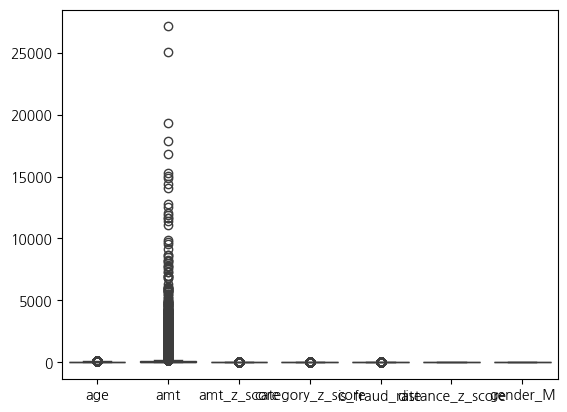

In [66]:
sns.boxplot(X_train)

In [67]:
from sklearn.preprocessing import RobustScaler

In [68]:
rs = RobustScaler()
X_train_scaled = rs.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled

,age,amt,amt_z_score,category_z_score,is_fraud_rate,distance_z_score,gender_M
0,-0.120000,-0.438248,-0.245238,-0.462301,-0.429984,-0.464426,0.000000
1,-0.520000,-0.586235,-0.173704,-0.224935,3.295769,0.167659,1.000000
2,0.040000,0.126088,0.377754,0.057108,0.381709,0.701489,0.000000
3,-0.920000,-0.599157,-0.226930,-0.396204,-0.521562,-0.937987,0.000000
4,0.120000,-0.044206,0.161592,-0.313074,2.035815,-0.114623,1.000000
...,...,...,...,...,...,...,...
666718,0.320000,-0.563520,0.075738,-0.701330,-0.348972,0.151480,1.000000
666719,-0.160000,0.573041,0.254706,-1.003738,1.496688,0.612879,1.000000
666720,-0.560000,0.360582,-0.090605,-0.591563,0.079589,-0.315241,1.000000
666721,-0.040000,-0.335691,-0.192562,-1.341387,-0.040409,0.400876,0.000000


In [69]:
X_valid = rs.transform(X_valid)
X_valid

array([[-0.64      , -0.59548422, -0.48221882, ...,  2.19722882,
        -0.44048817,  0.        ],
       [-0.56      , -0.41811752, -0.21385502, ..., -0.08226154,
        -0.79231353,  0.        ],
       [-0.36      , -0.19804135,  0.09767499, ...,  0.07270857,
         0.37729778,  1.        ],
       ...,
       [ 0.64      ,  0.19056039,  0.22230541, ..., -0.39583687,
        -0.22721376,  0.        ],
       [ 1.4       , -0.44749728, -0.65270298, ..., -0.35883193,
         0.36159699,  0.        ],
       [ 0.16      , -0.11289445, -0.43279266, ..., -0.2683236 ,
        -0.24926838,  0.        ]])

In [70]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [71]:
xgb = XGBClassifier(max_depth=5, n_estimators=500, n_jobs=-1, random_state=10)
xgb.fit(X_train_scaled, y_train)
valid_pred = xgb.predict(X_valid)
print(classification_report(y_valid, valid_pred))
print("roc_auc_score: ", roc_auc_score(y_valid, valid_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    442258
           1       0.74      0.55      0.63      2225

    accuracy                           1.00    444483
   macro avg       0.87      0.78      0.82    444483
weighted avg       1.00      1.00      1.00    444483

roc_auc_score:  0.776149855280468


In [72]:
y.value_counts()

is_fraud
0    1105643
1       5563
Name: count, dtype: int64

In [73]:
from imblearn.over_sampling import SMOTE

In [74]:
sm = SMOTE(random_state=10)
X_smt, y_smt = sm.fit_resample(X_train_scaled, y_train)

In [75]:
y_smt.value_counts()

is_fraud
0    663385
1    663385
Name: count, dtype: int64

In [76]:
len(X_valid)

444483

In [77]:
y_valid.value_counts()

is_fraud
0    442258
1      2225
Name: count, dtype: int64

In [78]:
xgb = XGBClassifier(max_depth=5, n_estimators=500, n_jobs=-1, random_state=10)
xgb.fit(X_smt, y_smt)
valid_pred = xgb.predict(X_valid)
print(classification_report(y_valid, valid_pred))
print("roc_auc_score: ", roc_auc_score(y_valid, valid_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    442258
           1       0.34      0.83      0.48      2225

    accuracy                           0.99    444483
   macro avg       0.67      0.91      0.74    444483
weighted avg       1.00      0.99      0.99    444483

roc_auc_score:  0.9098388199963201


In [86]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
#from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline

In [87]:
pipe = Pipeline([
    ('rs', RobustScaler()),
    ('smt', SMOTE(random_state=10)),
    ('rfc', RandomForestClassifier(n_jobs=-1, random_state=10))
])

In [91]:
# 랜덤서치를 위한 파라미터 정의

params_rv = {
    'rfc__n_estimators' : [100, 200, 300],
    'rfc__max_depth' : [3, 5, 7],
}

In [92]:
# 교차 검증을 위한 stratify-k-fold

scv = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)

In [93]:
random_cv = RandomizedSearchCV(pipe, param_distributions=params_rv, n_iter=10, 
                              scoring='roc_auc', cv=scv, random_state=10, n_jobs=-1)

random_cv.fit(X_train, y_train)
print("Best params:", random_cv.best_params_)
print("Best score:", random_cv.best_score_)
print("Best model test score:", random_cv.score(X_valid, y_valid))

Best params: {'rfc__n_estimators': 200, 'rfc__max_depth': 7}
Best score: 0.9813868117348192
Best model test score: 0.9238953580453647


## 여러개의 모델을 파이프라인으로 분석

In [106]:
models = { 'XGB' : XGBClassifier(n_jobs=-1, random_state=10),
           'RFC' : RandomForestClassifier(n_jobs=-1, random_state=10),
           'LGBM' : LGBMClassifier(n_jobs=-1, random_state=10)
         }
models

{'XGB': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=-1,
               num_parallel_tree=None, random_state=10, ...),
 'RFC': RandomForestClassifier(n_jobs=-1, random_state=10),
 'LGBM': LGBMClassifier(n_jobs=-1, random_state=10)}

In [107]:
params = {
    'XGB': {
        'XGB__max_depth': [3, 5, 7],
        'XGB__n_estimators': [100, 300, 500],
        'XGB__subsample': [0.6, 0.8, 1.0]
    },
    'RFC': {
        'RFC__max_depth': [3, 5, 7],
        'RFC__n_estimators': [100, 300, 500]
    },
    'LGBM': {
        'LGBM__max_depth': [3, 5, 7],
        'LGBM__n_estimators': [100, 300, 500],
        'LGBM__subsample': [0.6, 0.8, 1.0]
    }
}

In [108]:
# 각 모델별로 최적의 파라미터 찾고 성능 평가
best_estimators = {}
roc_auc_scores = {}
classification_reports = {}

In [109]:
skf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)

In [110]:
from sklearn.linear_model import LogisticRegression


In [111]:
pipe = Pipeline([
    ('rs', RobustScaler()),
    ('smt', SMOTE(random_state=10)),
    ('lr', LogisticRegression(n_jobs=3, random_state=10))
])

In [115]:
# 시간이 엄청 오래 걸림
# 주석처리 해놓기 

# %%time
for model_name, model in models.items():
    print(model_name, model)
    pipe = Pipeline([('rs', RobustScaler()),
                     ('smt', SMOTE(random_state=10)),
                     (model_name, model)])
    
    rand_cv = RandomizedSearchCV(pipe, param_distributions=params[model_name],
                                 cv=skf, scoring='roc_auc', n_jobs=3)

    rand_cv.fit(X_train, y_train)
    
    print('best_params: ', rand_cv.best_params_)
    best_model = rand_cv.best_estimator_
    best_pred = best_model.predict(X_valid)
    
    print(classification_report(y_valid, valid_pred))
    print('roc_auc_score: ', roc_auc_score(y_valid, valid_pred))


XGB XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=10, ...)
best_params:  {'XGB__subsample': 0.8, 'XGB__n_estimators': 100, 'XGB__max_depth': 5}
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    442258
           1       0.34      0.83      0.48     

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

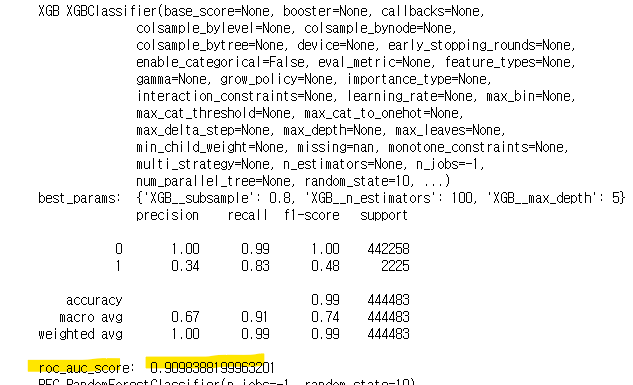

roc_auc_score:  0.9098388199963201

이게 중요한 것임. 

In [85]:
밑에서부턴 돌리지 말기 

SyntaxError: invalid syntax (3049010935.py, line 1)

# __________________________________________

In [ ]:
data['is_fraud'].value_counts()

# 0은 정상 거래
# 1은 사기

In [ ]:
data['job'].value_counts()

In [ ]:
job_counts = data['job'].value_counts()

for job, count in job_counts.items():
    print(f'{job}: {count}')

In [ ]:
data.isnull().sum()

In [ ]:
data.head(2)

In [ ]:
data['trans_date_trans_time']

In [ ]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

In [ ]:
data.info()

In [ ]:
data.head(7)

In [ ]:
data = data.drop(['first', 'last', 'street','city','zip','trans_num','unix_time'],axis=1)
data.head(3)

In [ ]:
data.info()

In [ ]:
#df = df.reset_index(drop=True)

In [ ]:
# 이름 + 성 합치기 

data['full_name'] = data['first'] + " " + data['last']
data.head()

In [ ]:
data['full_name']

In [ ]:
data = data.drop(['first', 'last'],axis=1)
data.head(3)

In [ ]:
data

In [ ]:
data.columns

In [ ]:
# 성별에 따른 사기 (=1) 여부 

data.groupby('gender')['is_fraud'].sum()

# 여자가 사기 비율이 조금 더 높다

In [ ]:
# 1은 사기, 0은 정상 거래

pd.crosstab(data['gender'], data['is_fraud'])

In [ ]:
data.groupby('gender')['is_fraud'].count()

In [ ]:
pd.crosstab(data['state'], data['is_fraud'])

In [ ]:
# 주별 사기 거래 수 (is_fraud == 1)
fraud_transactions_by_state = data[data['is_fraud'] == 1].groupby('state')['is_fraud'].count()

# NaN을 0으로 변경 (사기 거래가 없는 주는 비율이 NaN이 되므로 0으로 처리)
fraud_transactions_by_state = fraud_transactions_by_state.fillna(0)

In [ ]:
fraud_transactions_by_state.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Fraud Transactions by State')
plt.xlabel('State')
plt.ylabel('Number of Fraud Transactions')
plt.show()

미국에서 NY 뉴욕의 사기 거래 비율이 제일 높은 것을 확인할 수 있다. 

In [ ]:
# 각 주별 사기 거래(1) 수가 가장 높은 순서대로 상위 10개 주를 출력

fraud_transactions_by_state = data[data['is_fraud'] == 1].groupby('state')['is_fraud'].count()
top_10_fraud_states = fraud_transactions_by_state.sort_values(ascending=False).head(10)
print(top_10_fraud_states)


* NY: New York (뉴욕)
* TX: Texas (텍사스)
* PA: Pennsylvania (펜실베이니아)
* CA: California (캘리포니아)
* OH: Ohio (오하이오)

In [ ]:
# 거래 금액(amt)과 사기 여부의 관계
data['amt']

In [ ]:
data.groupby('is_fraud')['amt'].describe()

In [ ]:
data.groupby('is_fraud')['amt'].mean()

# 평균 사기 금액 : 530 불 

In [ ]:
# 사기 거래 당한 수가 많은 상위 10개 직업군

data[data['is_fraud'] == 1]['job'].value_counts().head(10)

- Quantity surveyor: 건설 원가 계산사
- Naval architect: 선박 건조 기술자
- Materials engineer: 재료 공학자
- Audiological scientist: 청각 과학자
- Senior tax professional/tax inspector: 고위 세무 전문가/세무 조사관
- Trading standards officer: 거래 기준 감독관
- Podiatrist: 족부 전문의
- Film/video editor: 영화/비디오 편집자
- Colour technologist: 색채 기술자
- Exhibition designer: 전시 디자이너